<a href="https://colab.research.google.com/github/Cordeir0/Pseudocode/blob/main/otimizacao_sistema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# trabalho de otimização de sistemas
# alunos participantes
#- Lucas Eduardo dos Santos Cordeiro - 2017102622
#- Alice do Nascimento Barreto - 2021100592
#- Samara Martins Farias - 2021100269
import yfinance as yf
import pandas as pd

#lista de ações
acao = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

#definição de cor
cores= ['red', 'blue', 'green', 'purple', 'yellow']

#coleta de dados historicos das ações
data = yf.download(acao, start='2023-01-01', end='2024-01-01')['Adj Close']

#calcula os retornos diários dos preços ajustados
retornos_diarios = data.pct_change(fill_method=None).dropna()

#calcula o retorno esperado e a volatilidade de cada ativo
retornos_esperado = retornos_diarios.mean() * 252
volatilidade = retornos_diarios.std() * (252 ** 0.5)

[*********************100%***********************]  5 of 5 completed


In [2]:
from scipy.optimize import minimize
import numpy as np

#função para calcular o retorno esperado da carteira com base nos pesos dos ativos
def portfolio_retorno(pesos, retornos_diarios):
    return np.sum(retornos_diarios * pesos)

#função para calcular a volatilidade da carteira (risco) com base nos pesos dos ativos
def portfolio_vol(pesos, cov_matrix):
    return np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

#função objetivo para minimizar o risco respeitando o retorno alvo
def minimizar_risco (pesos, retornos_diarios, cov_matrix, target_return):
    if portfolio_retorno (pesos, retornos_diarios) < target_return:
        return 1e10  #função objetivo para minimizar o risco, respeitando o retorno alvo
    return portfolio_vol(pesos, cov_matrix)

#função objetivo para minimizar o risco respeitando o retorno alvo
cov_matrix = retornos_diarios.cov() * 252

#função objetivo para minimizar o risco, respeitando o retorno alvo
num_assets = len(acao)
pesos = np.array([1/num_assets] * num_assets)
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somatório dos pesos igual a 1
               {'type': 'ineq', 'fun': lambda x: portfolio_retorno(x, retornos_esperado) - 0.15}]  # Retorno mínimo

#otimização para encontrar a distribuição de pesos que minimiza o risco
resultado = minimize(minimizar_risco, pesos, args=(retornos_esperado, cov_matrix, 0.15), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = resultado.x

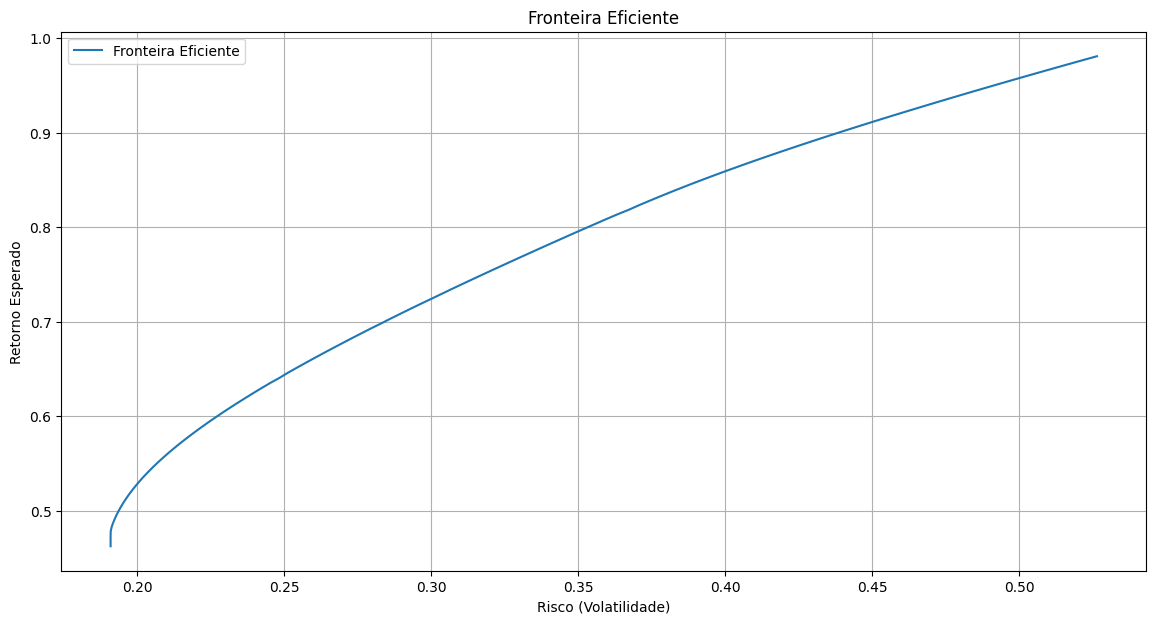

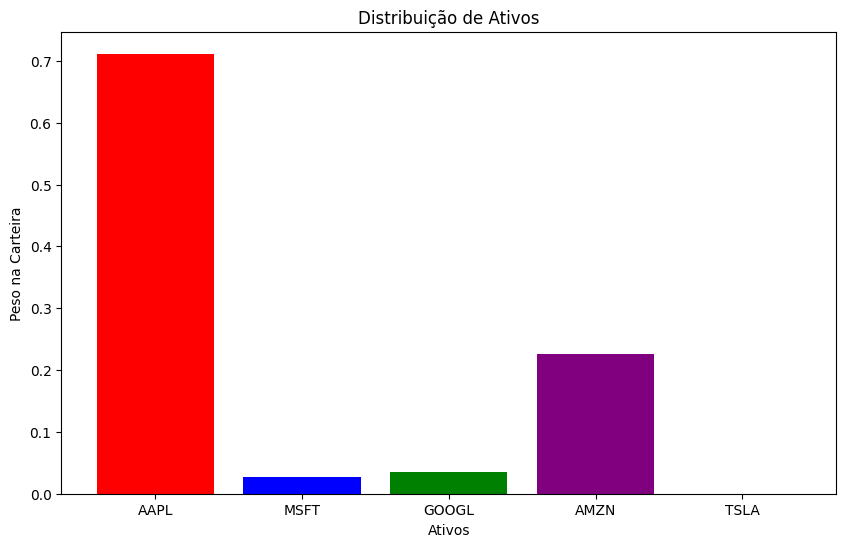

Text(0, 0.5, 'Retorno Acumulado')

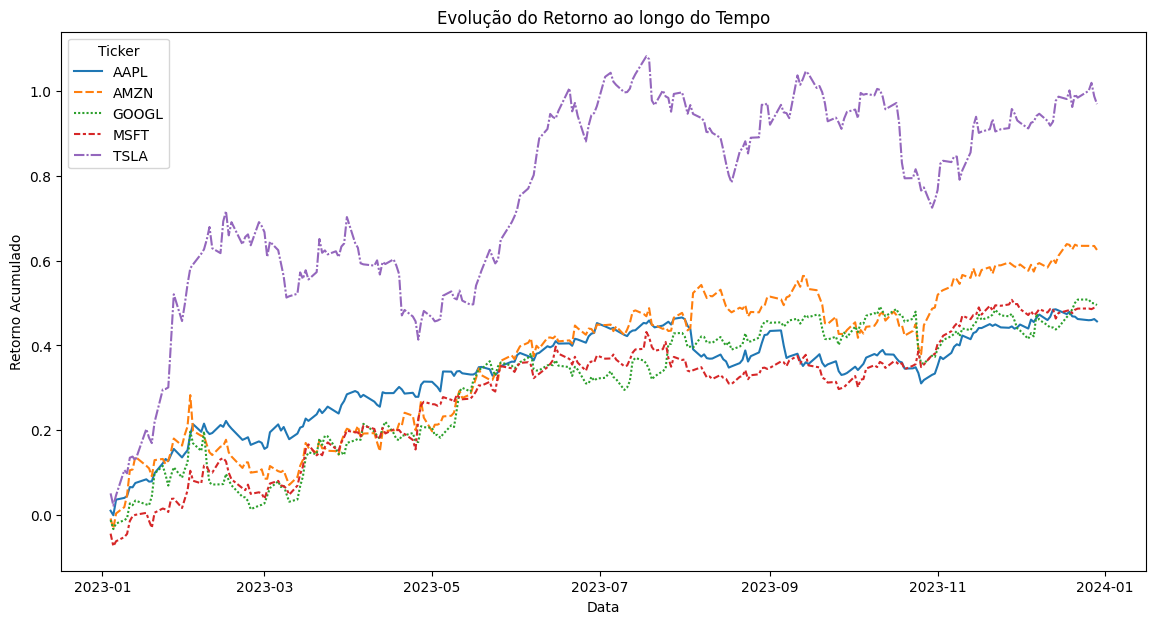

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#calcula a fronteira eficiente variando os retornos esperados e calculando os riscos correspondentes
retornos_diarios_range = np.linspace(min(retornos_esperado), max(retornos_esperado), 100)
risks = []

for r in retornos_diarios_range:
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: portfolio_retorno(x, retornos_esperado) - r}]
    res = minimize(minimizar_risco, pesos, args=(retornos_esperado, cov_matrix, r), method='SLSQP', bounds=bounds, constraints=cons)
    risks.append(portfolio_vol(res.x, cov_matrix))
#plot da Fronteira Eficiente mostrando a relação entre risco e retorno esperado
plt.figure(figsize=(14, 7))
plt.plot(risks, retornos_diarios_range, label='Fronteira Eficiente')
plt.xlabel('Risco (Volatilidade)')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente')
plt.legend()
plt.grid()
plt.show()

#plot da Fronteira Eficiente mostrando a relação entre risco e retorno esperado
plt.figure(figsize=(10, 6))
plt.bar(acao, optimal_weights, color=cores)
plt.xlabel('Ativos')
plt.ylabel('Peso na Carteira')
plt.title('Distribuição de Ativos')
plt.show()

#plot da Evolução do Retorno Acumulado ao longo do Tempo
plt.figure(figsize=(14, 7))
sns.lineplot(data=retornos_diarios.cumsum())
plt.title('Evolução do Retorno ao longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
